# Computation of the Average Precision

In [1]:
# Imports
%matplotlib inline
import json
import os
import matplotlib.pyplot as plt
from AxonDeepSeg.testing.segmentation_scoring import *
import pickle

from time import time
#from ipywidgets.widgets import *
from scipy.misc import imread, imsave

# 1/ Define the parameters to use for the segmentation

In [2]:
# input data to build the training set
dataset_name = 'SEM_3c_512'
gps = 0.1
path_data = '../data/' + dataset_name + '/raw/'
path_testing = '../data/baseline_testing/SEM_data15/'
#path_testing = '../data/images_nyu_tem/'

# output path of training data path
path_training = '../data/' + dataset_name + '/training/'

Choose the model to evaluate

In [3]:
model_name = 'model_1_0_1018'

In [4]:
# optional input path of a model to initialize the training
path_model_init = None

# output path for trained U-Net
path_model = '../models/' + model_name
path_configfile = path_model + '/config_network.json'

if not os.path.exists(path_model):
    os.makedirs(path_model)

with open(path_configfile, 'r') as fd:
    config_network = json.loads(fd.read())
    
# OPTIONAL : specify the gpu one wants to use.
gpu_device = 'gpu:0' # or gpu_device = 'gpu:1' these are the only two possible targets for now.

# 3/ Apply the model to segment one image

In [5]:
from AxonDeepSeg.apply_model import axon_segmentation

In [6]:
pred, pred_proba = axon_segmentation([path_testing], ["image.png"], path_model, config_network, overlap_value=25, resampled_resolutions=gps, 
                                  prediction_proba_activate=True, write_mode=True, inference_batch_size=4, gpu_per=0.3, verbosity_level=0)

** TRANSFORMING PRED_PROBA INTO REAL PROBABILITIES **

In [7]:
pred_proba = pred_proba[0]
a = np.exp(pred_proba)
b = np.sum(a, axis=-1)
c = np.stack([np.divide(a[:,:,i],b) for i in range(3)], axis=-1)

In [28]:
probability_map=c

In [29]:
mask = imread(path_testing + '/mask.png', flatten=True)

In [30]:
ground_truth=np.zeros_like(probability_map)
for i,elem in enumerate(np.unique(mask)):
    print elem
    print i
    ground_truth[:,:,i]=1.0*(mask==elem)

0.0
0
128.0
1
255.0
2


# 4/ Average Precision computation

First, we fuse the 2 spatial dimensions of the arrays

In [11]:
probability_map=np.reshape(probability_map,(probability_map.shape[0]*probability_map.shape[1],probability_map.shape[2]))
ground_truth=np.reshape(ground_truth,(ground_truth.shape[0]*ground_truth.shape[1],ground_truth.shape[2]))

In [12]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
n_classes=3
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(ground_truth[:, i],
                                                        probability_map[:, i])
    average_precision[i] = average_precision_score(ground_truth[:, i], probability_map[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(ground_truth.ravel(),
    probability_map.ravel())
average_precision["micro"] = average_precision_score(ground_truth, probability_map,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.93


In [13]:
precision

{0: array([0.38579679, 0.38579596, 0.38579648, ..., 1.        , 1.        ,
        1.        ]),
 1: array([0.44647847, 0.44647771, 0.44647832, ..., 1.        , 1.        ,
        1.        ]),
 2: array([0.30206155, 0.30206071, 0.30206107, ..., 1.        , 1.        ,
        1.        ]),
 'micro': array([0.36847079, 0.36847068, 0.36847099, ..., 1.        , 1.        ,
        1.        ])}

In [14]:
import seaborn as sns
sns.set(font_scale=1.2)
#sns.set(font_scale=1.5, rc={'text.usetex' : True}) 

Text(0.5,1,u'Average precision score\nmicro-averaged over all classes: AP=0.93')

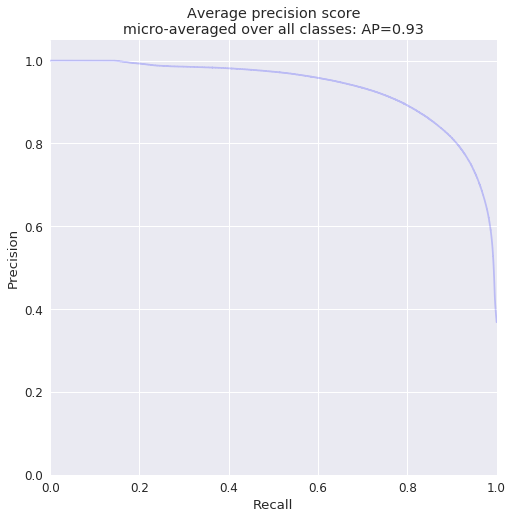

In [15]:
plt.figure(figsize=(8,8))
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
#plt.fill_between(recall["micro"], precision["micro"], step='post', alpha=1)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score\nmicro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

In [16]:
import pickle

In [17]:
path_saving=os.path.join('../models/',model_name)

save_dict={'recall':recall,
           'precision':precision,
           'mAP':average_precision}
with open(os.path.join(path_saving, 'precision_recall_curve.pkl'), 'w') as handle:
    pickle.dump(save_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

# 5/ Compare different models

In [19]:
# Define models to load
L_models=['baseline_classic','model_1_0_1018']

# Display the plots
plt.figure(figsize=(8,8))
L_colors=['b','r']
for i, model in enumerate(L_models):
    pr_data = pickle.load( open( os.path.join('../models/',model,'precision_recall_curve.pkl'), "rb" ) )
    plt.step(pr_data['recall']['micro'], pr_data['precision']['micro'], color=L_colors[i], alpha=0.2,
         where='post',label=model)
    
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.show()

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

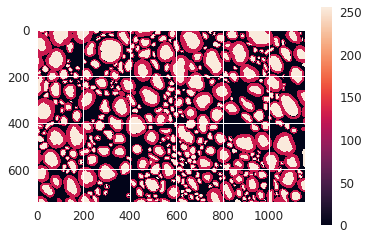

In [26]:
plt.figure()
plt.imshow(mask)
plt.colorbar()
plt.show()